In [103]:
# Valery Vishnevskiy, CMR, ETH Zurich
# 23.03.2020

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

tf_dt = tf.complex64
np_dt = np.complex64

@tf.function
def relax(t, T1, T2, mag):
    # t:     Nbatch
    # T1,T2: Nbatch-1-Niso
    # mag:   Nbatch-3-Niso-Nepg
    
    mask = np.zeros([1, 3, 1, mag.shape[3]], dtype = np_dt)
    mask[:, 2, :, 0] = 1.
    
    tmp1 = tf.exp(-t/T2) # Nb - 1 - Niso
    tmp2 = tf.exp(-t/T1)
    
    tmp1 = tf.cast(tmp1, tf_dt)
    tmp2 = tf.cast(tmp2, tf_dt)
    
    tmp = tf.concat([tmp1, tmp1, tmp2], 1) #Nb-3-Niso
    tmp = tf.expand_dims(tmp, 3) # Nb-3-Niso-1
    mag2 = tmp * mag # decay
    
    tmp3 = tf.expand_dims(1. - tf.exp(-t/T1), 3)
    tmp3 = tf.cast(tmp3, tf_dt)
    
    mag2 =(1-mask) * mag2 +  mask * (tmp3 + mag2) # relaxation
    return mag2

@tf.function
def spoil(mag):
    # mag: Nbatch-3-Niso-Nepg
    msk0 = np.zeros([1, 3, 1, 1], dtype = np_dt)
    msk0[:, 0, :, :] = 1
    msk1 = np.zeros([1, 3, 1, 1], dtype = np_dt)
    msk1[:, 1, :, :] = 1
    
    msk2 = np.zeros([1, 3, 1, mag.shape[3]], dtype = np_dt)
    msk2[:, 1, :, -1] = 1
    msk3 = np.zeros([1, 3, 1, mag.shape[3]], dtype = np_dt)
    msk3[:, 0, :, 0] = 1
    
#     mag0 = tf.zeros_like(mag)
    mag0 = tf.identity(mag)
    mag0 = (1 - msk0) * mag0 + msk0 * tf.roll(mag, 1, 3)
    mag0 = (1 - msk1) * mag0 + msk1 * tf.roll(mag, -1, 3)
    
    mag0 *= (1 - msk2)
    
    mag0 = (1 - msk3) * mag0 + msk3 * tf.math.conj(tf.roll(mag0, -1, 1))
    
    return mag0
    
@tf.function
def RMat(phi, alpha):
# phi: Nbatch
# alpha: Nbatch
# returns rot matrices Nbatch-3-3

# RMat Makes Rotation Matrix for RF Pulse
# phi    RF pulse phase       (rad)
# alpha  RF flip angle        (rad)
# Source: Weigel, M. Extended phase graphs: Dephasing, RF pulses, and echoes - pure and simple. J. Magn. Reson. Imaging 41, 266�295 (2015).
    phi_ = tf.reshape(phi, [-1])
    alpha_ = tf.reshape(alpha, [-1])
    phi_ = tf.reshape(phi, [-1])
    
    alpha_ = tf.cast(alpha_, tf_dt)
    phi_ = tf.cast(phi_, tf_dt)
    
    m00 = tf.cos(alpha_/2.)**2
    m01 = tf.exp(2*1j*phi_) * tf.sin(alpha_/2.)**2
    m02 = -1j * tf.exp(1j*phi_) * tf.sin(alpha_)
    m10 = tf.exp(-2*1j*phi_) * tf.sin(alpha_/2.)**2 
    m11 = tf.cos(alpha_/2.)**2 
    m12 = 1j * tf.exp( -1j * phi_) * tf.sin(alpha_)
    m20 = -1j/2. * tf.exp(-1j*phi_) * tf.sin(alpha_) 
    m21 = 1j/2. * tf.exp(1j * phi_) * tf.sin(alpha_)  
    m22 = tf.cos(alpha_)
    
    mtx = tf.stack([m00,m01,m02,  m10,m11,m12,  m20,m21,m22])
    mtx = tf.reshape(mtx, [-1, 3, 3])
    return mtx
    
#@tf.function
def FispMRF(FA, TR, T1, T2, TE):
    # all shapes broadcastable to : Nbatch-N-Niso
    Nb = tf.cast(FA.shape[0], tf.int64)
    assert Nb == 1
    N = FA.shape[1]
    Nepg = tf.cast(tf.math.ceil(N/2.), tf.int64)
    Niso = tf.cast(T1.shape[2], tf.int64)
    
    mag0 = np.zeros([Nb, 3, Niso, Nepg], dtype = np_dt)
    mag0[:, 2, :, 0] = 1.
    mag = tf.cast(mag0, tf_dt)
    out = []
    
    for i in range(N):
        a1 = tf.math.angle(FA[:, i, 0])
        a2 = tf.abs(FA[:, i, 0])
        rotmat = RMat(a1, a2)
        rotmat = tf.reshape(rotmat, [3,3])
        
        mag = tf.transpose(mag, [0, 2,3, 1])
        mag = tf.linalg.matvec(rotmat, mag)
        mag = tf.transpose(mag, [0, 3, 1, 2])
        
        mag = relax(TE[:, i, 0], T1, T2, mag)
        
        out.append(mag[:, 0, :, 0])
        
        mag = spoil(mag)
        
        mag = relax(TR[:, i, 0] - TE[:, i, 0], T1, T2, mag)
    out = tf.stack(out, 1)
    return out
        
#### test
N = 101
FA = (  np.sin(np.linspace(0, np.pi, N - 1)) * .7\
      + np.sin(np.linspace(0, 2*np.pi, N - 1)) * .3 + \
        np.sin(np.linspace(0, 3*np.pi, N - 1)) * .15 + 0.1) * 60./180.*np.pi

FA = np.concatenate([[np.pi], FA])


TR = 15;
TE = 3;
T1 = np.concatenate([[1], range(5,101, 5), range(110, 201, 10), range(250, 1001, 50), range(1100, 5001,100)])
T2 = np.concatenate([range(1,11), range(12, 51, 2), range(55, 201, 5), range(210, 301,10), range(320, 501,20), range(550, 1001,50)])
[T1,T2] = np.meshgrid(T1,T2, indexing = 'ij')
T1 = np.ravel(T1)
T2 = np.ravel(T2)
I = (T1>T2)
T1 = T1[I]
T2 = T2[I]

Nb = 1

FA = np.reshape(FA, [Nb, N, 1])
TR = np.reshape(TR, [Nb, 1, 1])
TR = np.broadcast_to(TR, [Nb, N, 1])
TE = np.reshape(TE, [Nb, 1, 1])
TE = np.broadcast_to(TE, [Nb, N, 1])

T1 = np.reshape(T1, [Nb, 1, -1])
T2 = np.reshape(T2, [Nb, 1, -1])

print(T1.shape, T2.shape, FA.shape, TR.shape, TE.shape, FA.shape)


%time r = FispMRF(FA,TR,T1,T2,TE)
    

(1, 1, 5902) (1, 1, 5902) (1, 101, 1) (1, 101, 1) (1, 101, 1) (1, 101, 1)
CPU times: user 2.21 s, sys: 40.6 ms, total: 2.25 s
Wall time: 3.2 s


(1, 101, 5902)


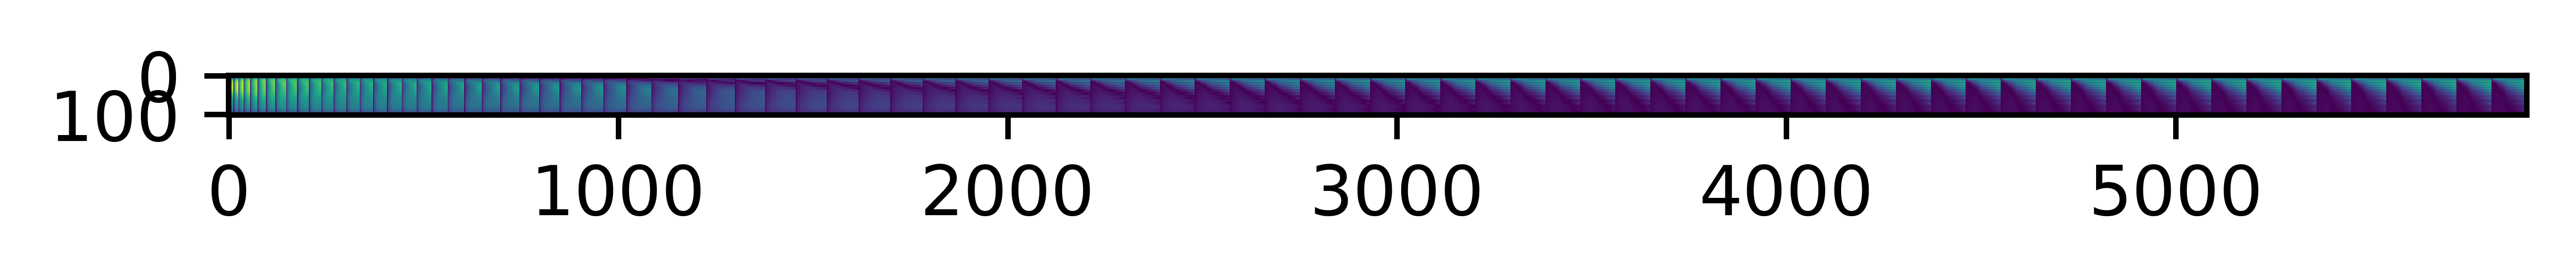

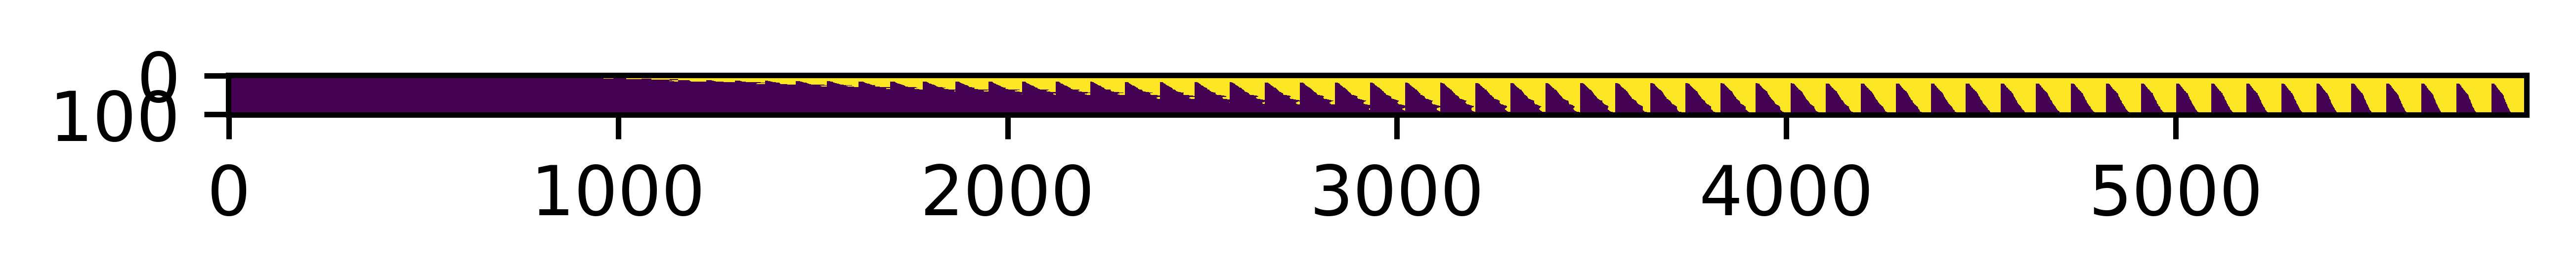

In [104]:
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 500
%config InlineBackend.figure_format ='retina'

print(r.shape)
plt.imshow(np.abs(np.squeeze(r)))
plt.show()
plt.imshow(np.angle(np.squeeze(r)))
plt.show()
# plt.plot(np.abs(np.ravel(FA)), 'r')
# plt.show()

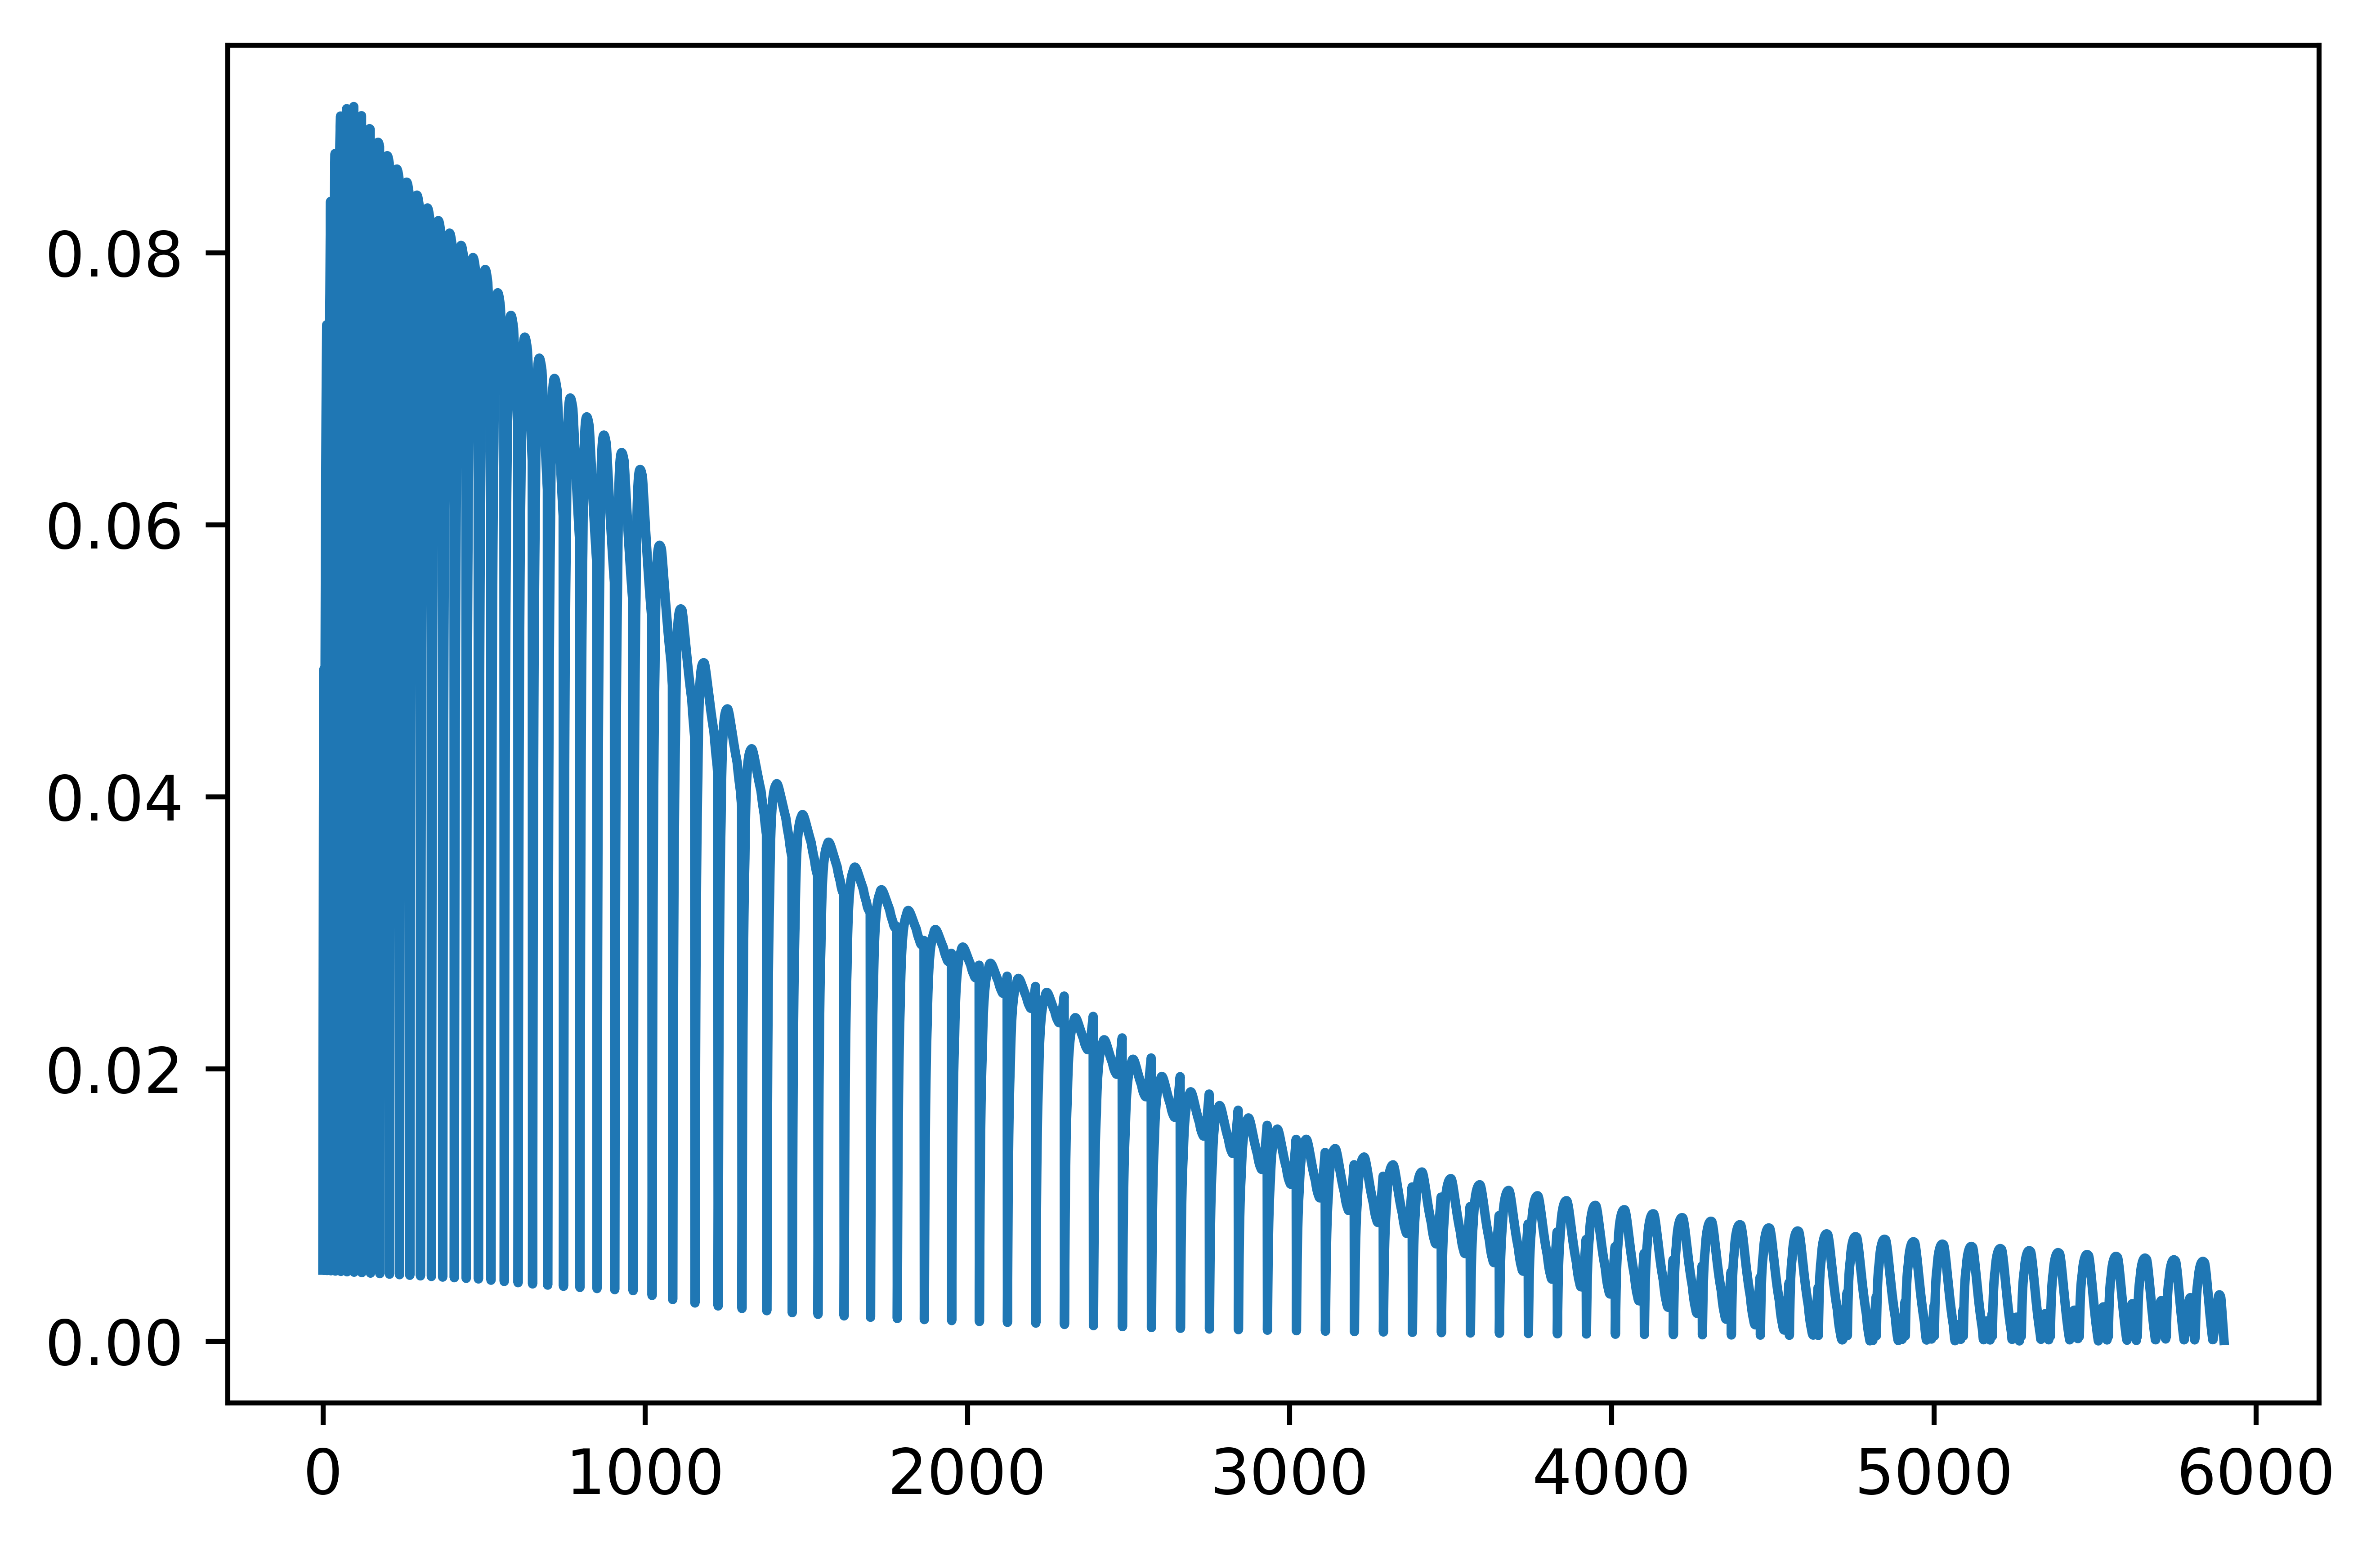

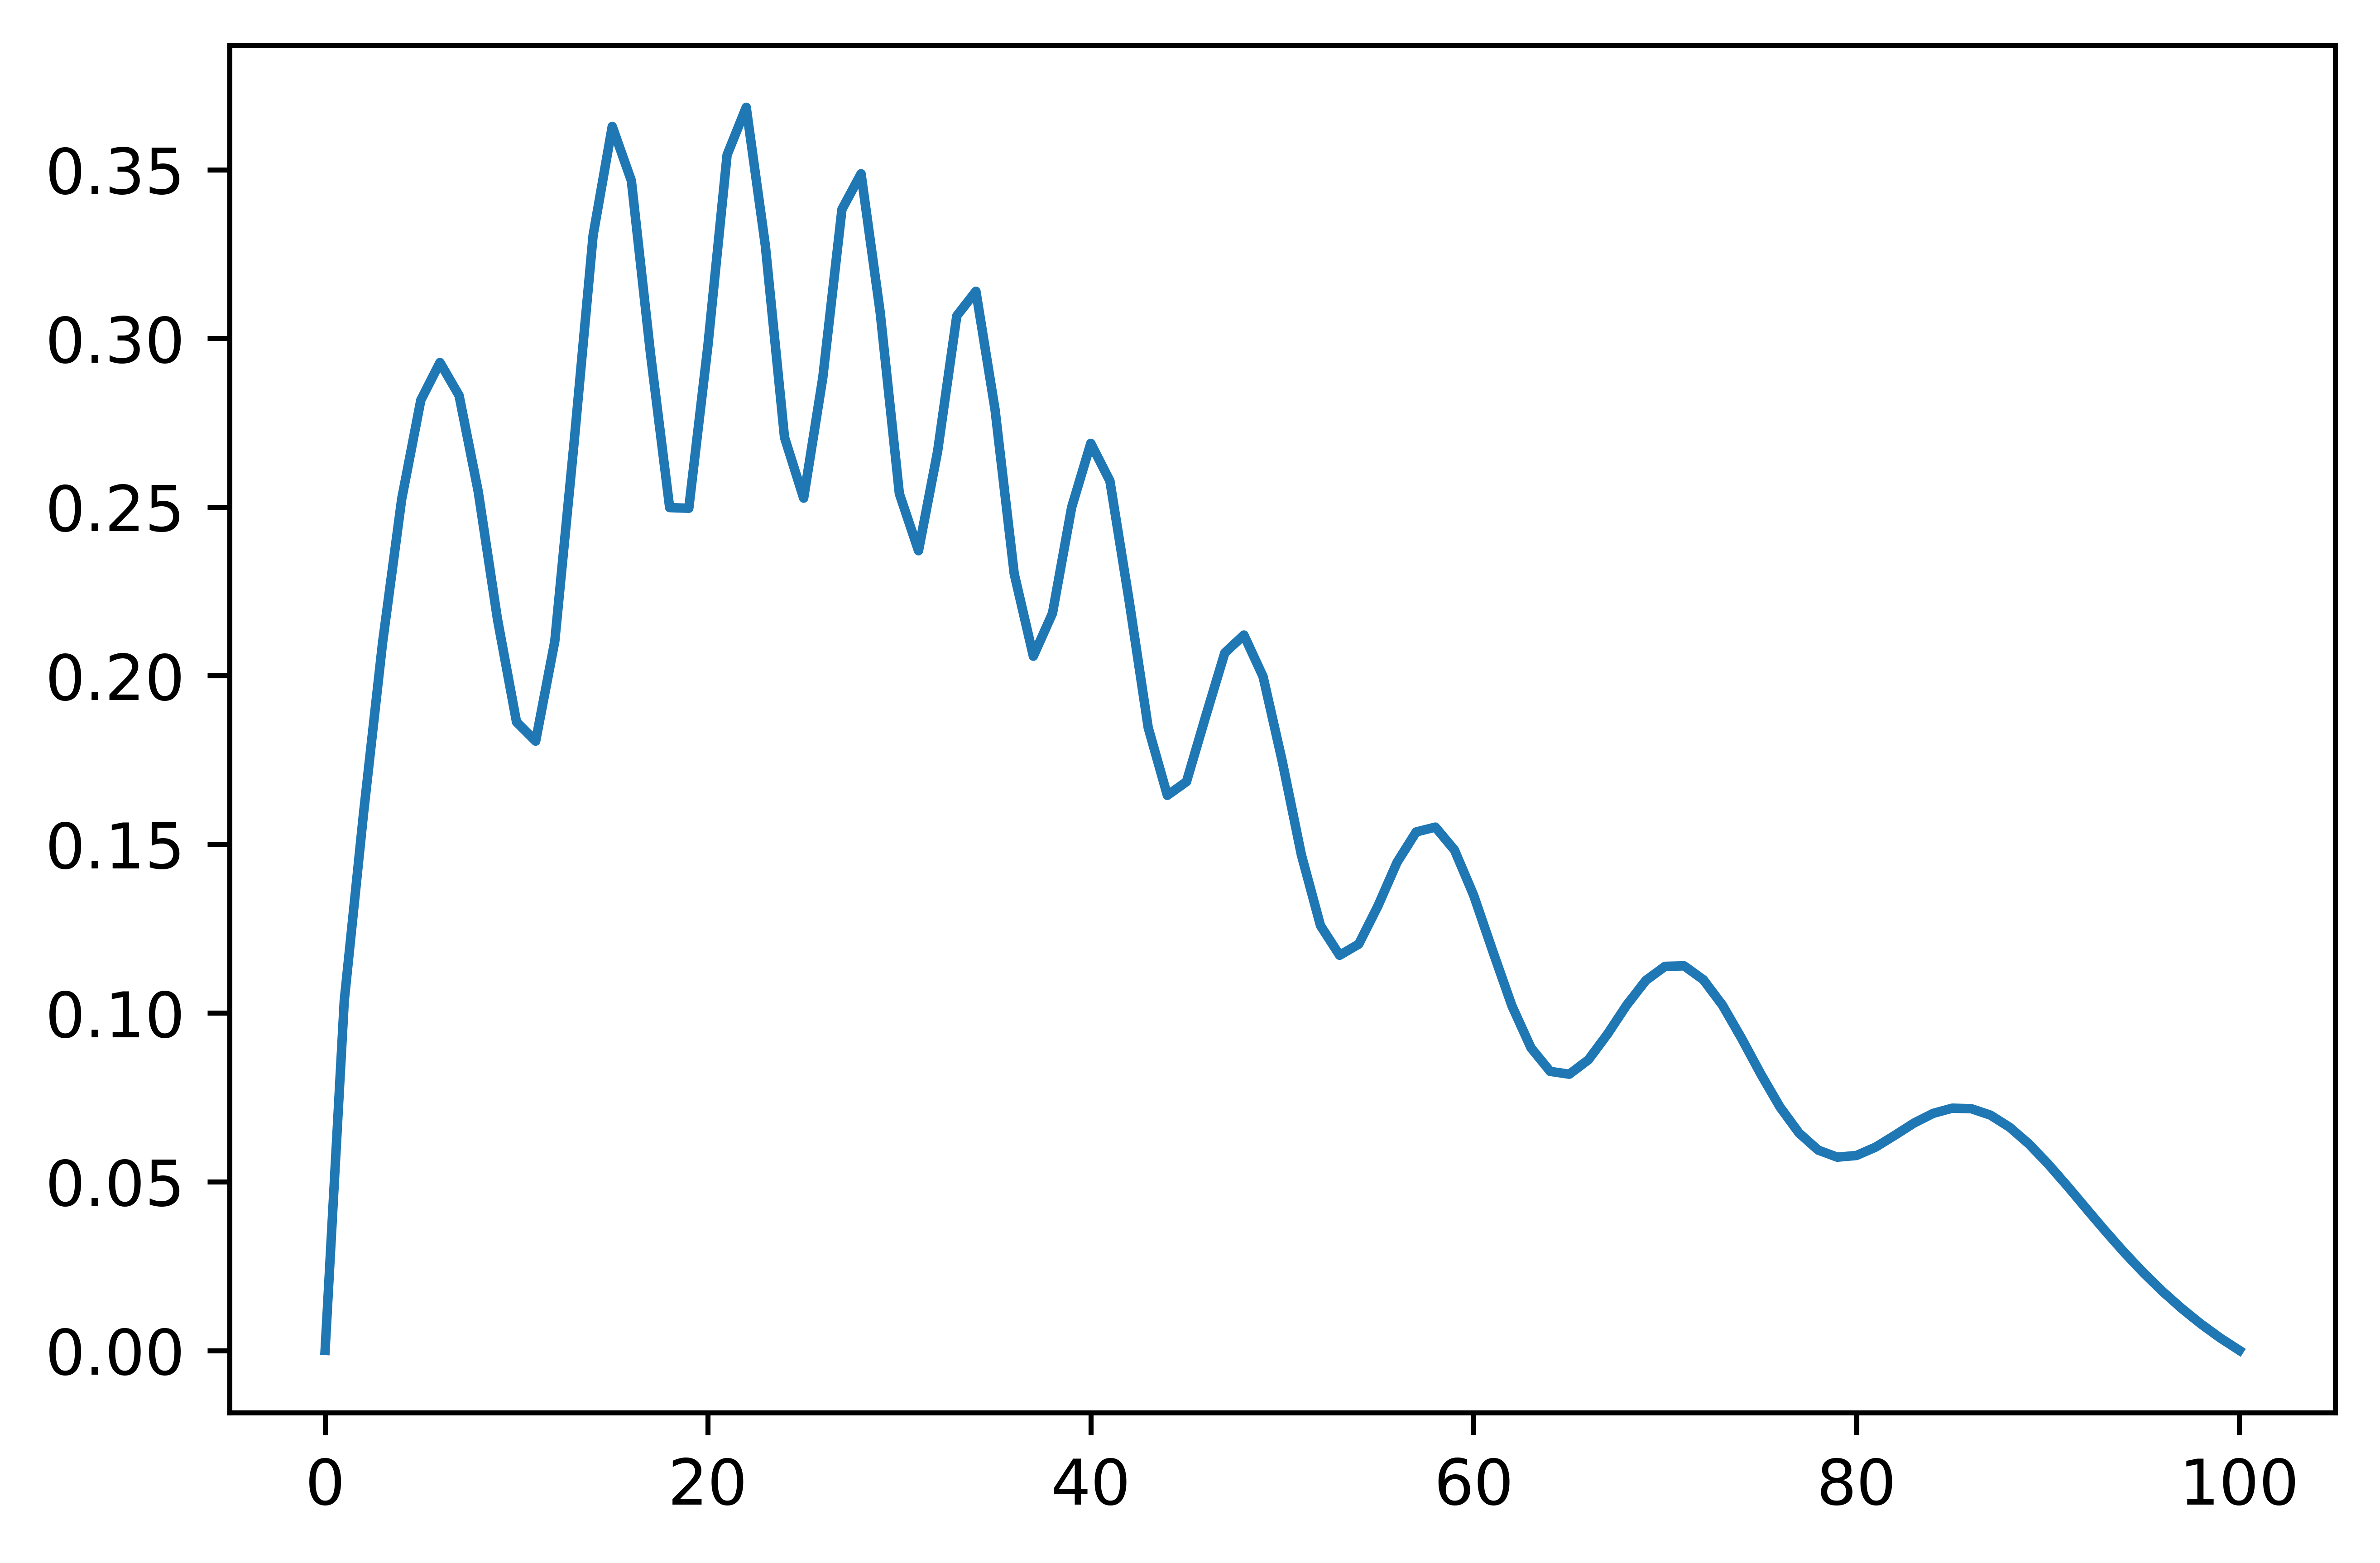

(1, 101, 5902)


In [105]:
plt.plot(np.abs(r[0, -1, :]))
plt.show()

plt.plot(np.abs(r[0, :, -1]))
plt.show()

print(r.shape)

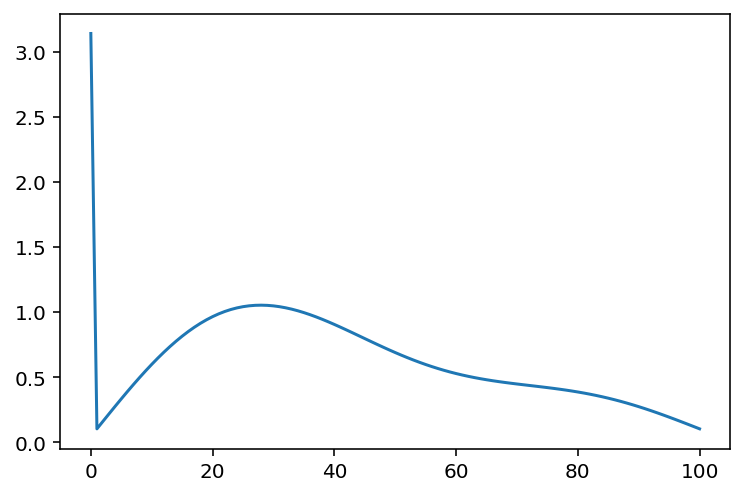

In [34]:
FA = (  np.sin(np.linspace(0, np.pi, N - 1)) * .7\
      + np.sin(np.linspace(0, 2*np.pi, N - 1)) * .3 + \
        np.sin(np.linspace(0, 3*np.pi, N - 1)) * .15 + 0.1) * 60./180.*np.pi

FA = np.concatenate([[np.pi], FA])
plt.plot(FA)